# Import modules

In [2]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# Collecting data

- In this project, the model will be designed to recognize 5 faces so I have collected images for 5 persons and process them as you will see in code.

In [60]:
# Initializing anchor, positive and negative paths.
# This step should be done for every person will join to data.

POS_PATH = os.path.join('Face_Recognition_Data', 'Mustafa', 'positive')
NEG_PATH = os.path.join('Face_Recognition_Data', 'Mustafa', 'negative')
ANC_PATH = os.path.join('Face_Recognition_Data', 'Mustafa', 'anchor')

In [4]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened(): 
    ret, frame = cap.read()
#     frame = frame[100:350, 100:350, :]
   
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# Preparing data

step 1: Collecting data and splitting it manually into 5 folders as we have 5 persons in data.

step 2: Each folder must have 3 folders which are anchor, positive and negative.
        (ex: 'Mustafa' is a folder has 3 folders anchor, positive and negative. anchor and positive folders should have images            for Mustafa. Negative folder should have images for any person in data except Mustafa).
        
step 3: Augmentation to increase data to make each folder has 1200 images.

In [67]:
def data_aug(img):
    data = []
    for i in range(15):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [6]:
for person in os.listdir('Face_Recognition_Data'):
    
    for folder in os.listdir(os.path.join('Face_Recognition_Data', person)):
        
        path = os.path.join('Face_Recognition_Data', person, folder)
        for image in os.listdir(path):
            img_path = os.path.join(path, image)
            img = cv2.imread(img_path)
            
            augmented_images = data_aug(img)
            for aug in augmented_images:
                cv2.imwrite(os.path.join('Face_recognition_augdata', person, folder, '{}.jpg'.format(uuid.uuid1())), aug.numpy())

# Load and Preprocess Images

## 1- Get Image Directories

In [2]:
M_anchor = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Mustafa', 'anchor')+'\*.jpg').shuffle(1500).take(1200)
M_positive = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Mustafa', 'positive')+'\*.jpg').shuffle(1500).take(1200)
M_negative = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Mustafa', 'negative')+'\*.jpg').shuffle(1500).take(1200)

A_anchor = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Ahmed', 'anchor')+'\*.jpg').shuffle(1500).take(1200)
A_positive = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Ahmed', 'positive')+'\*.jpg').shuffle(1500).take(1200)
A_negative = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Ahmed', 'negative')+'\*.jpg').shuffle(1500).take(1200)

Y_anchor = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Youssef', 'anchor')+'\*.jpg').shuffle(1500).take(1200)
Y_positive = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Youssef', 'positive')+'\*.jpg').shuffle(1500).take(1200)
Y_negative = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Youssef', 'negative')+'\*.jpg').shuffle(1500).take(1200)

K_anchor = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Kareem', 'anchor')+'\*.jpg').shuffle(1500).take(1200)
K_positive = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Kareem', 'positive')+'\*.jpg').shuffle(1500).take(1200)
K_negative = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Kareem', 'negative')+'\*.jpg').shuffle(1500).take(1200)

B_anchor = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Bassant', 'anchor')+'\*.jpg').shuffle(1500).take(1200)
B_positive = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Bassant', 'positive')+'\*.jpg').shuffle(1500).take(1200)
B_negative = tf.data.Dataset.list_files(os.path.join('Face_Recognition_augdata', 'Bassant', 'negative')+'\*.jpg').shuffle(1500).take(1200)

In [3]:
dir_test = M_anchor.as_numpy_iterator()

In [4]:
print(dir_test.next())

b'Face_Recognition_augdata\\Mustafa\\anchor\\612afba6-3c1b-11ed-910c-3c2c30f4fd65.jpg'


## 2- Create Labelled Dataset

In [5]:
M_positives = tf.data.Dataset.zip((M_anchor, M_positive, tf.data.Dataset.from_tensor_slices(tf.ones(1200))))
M_negatives = tf.data.Dataset.zip((M_anchor, M_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1200))))
M_data = M_positives.concatenate(M_negatives)

A_positives = tf.data.Dataset.zip((A_anchor, A_positive, tf.data.Dataset.from_tensor_slices(tf.ones(1200))))
A_negatives = tf.data.Dataset.zip((A_anchor, A_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1200))))
A_data = A_positives.concatenate(A_negatives)

Y_positives = tf.data.Dataset.zip((Y_anchor, Y_positive, tf.data.Dataset.from_tensor_slices(tf.ones(1200))))
Y_negatives = tf.data.Dataset.zip((Y_anchor, Y_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1200))))
Y_data = Y_positives.concatenate(Y_negatives)

K_positives = tf.data.Dataset.zip((K_anchor, K_positive, tf.data.Dataset.from_tensor_slices(tf.ones(1200))))
K_negatives = tf.data.Dataset.zip((K_anchor, K_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1200))))
K_data = K_positives.concatenate(K_negatives)

B_positives = tf.data.Dataset.zip((B_anchor, B_positive, tf.data.Dataset.from_tensor_slices(tf.ones(1200))))
B_negatives = tf.data.Dataset.zip((B_anchor, B_negative, tf.data.Dataset.from_tensor_slices(tf.zeros(1200))))
B_data = B_positives.concatenate(B_negatives)

data = M_data.concatenate(A_data)
data = data.concatenate(Y_data)
data = data.concatenate(K_data)
data = data.concatenate(B_data)

In [9]:
samples = data.as_numpy_iterator()

In [10]:
example = samples.next()

In [11]:
example

(b'Face_Recognition_augdata\\Mustafa\\anchor\\12253c2f-3c1b-11ed-9d30-3c2c30f4fd65.jpg',
 b'Face_Recognition_augdata\\Mustafa\\positive\\8e7fba9f-3c1b-11ed-b889-3c2c30f4fd65.jpg',
 1.0)

## 3- Preprocessing - Scale and Resize

In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [78]:
img = preprocess('Face_Recognition_augdata\\Mustafa\\anchor\\38725651-3c1b-11ed-92f7-3c2c30f4fd65.jpg')

In [79]:
img.numpy().max()

0.907523

## 4- Build Train and Test Partition

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
res = preprocess_twin(*example)

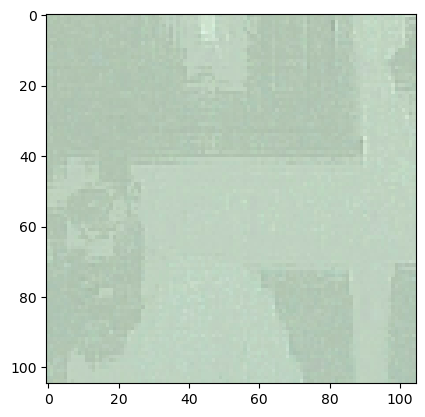

In [14]:
plt.imshow(res[1])

In [15]:
res[2]

1.0

In [16]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=40000)

In [17]:
# Training partition
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [18]:
# Testing partition
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model

## 1- Import tensorflow dependencies

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 2- Build Embedding Layer

In [20]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## 3- Build Distance Layer

In [23]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()

## 4- Make Siamese Model

In [25]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()

In [27]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

## 1- Setup Loss and Optimizer

In [28]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [29]:
opt = tf.keras.optimizers.Adam(1e-4)

## 2- Build Train Step Function

In [30]:
test_batch = train_data.as_numpy_iterator()

In [31]:
batch_1 = test_batch.next()

In [32]:
X = batch_1[:2]

In [33]:
y = batch_1[2]

In [34]:
y

array([1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

In [35]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

# 3- Build Training Loop

In [36]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [37]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

## 4- Train the model

In [55]:
EPOCHS = 50

In [56]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


Exception ignored in: <function UniquePtr.__del__ at 0x00000296E1A92550>
Traceback (most recent call last):
  File "D:\Machine\venv_camtest\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [38]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# Evaluate Model

## 1- Make Predictions

In [39]:
# Get a batch of test data
test_batch = test_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
test_input, test_val = batch_1[:2]

In [40]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


In [41]:
# Post processing the results 
pred = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
pred

[1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1]

In [42]:
y_true = batch_1[2]
y_true

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

## 2- Calculate Metrics

In [43]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 1s/step
0.74382716 0.5950617


## 3- Viz Results

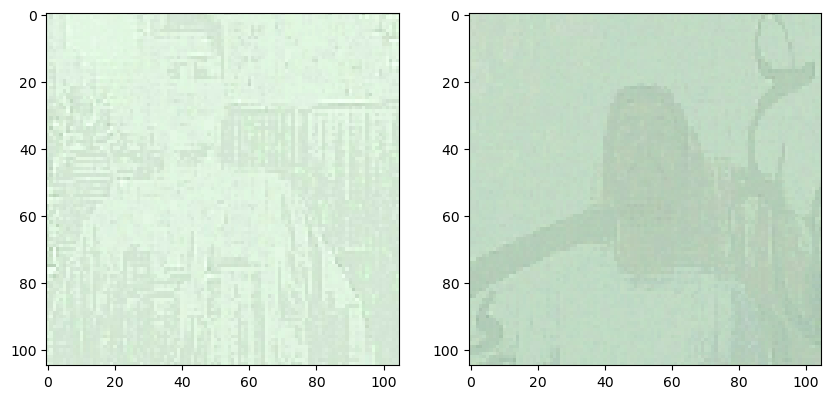

In [45]:
i = 12

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[i])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[i])

# Renders cleanly
plt.show()

print(pred[i])

# Real time test

## 1- Verification Function

In [46]:
def verify(model, detection_threshold, verification_threshold):
    
    person = ''
    score = 0.1
    
    for folder in os.listdir(os.path.join('application_data', 'verification_images')):
        # Build results array
        results = []
        for image in os.listdir(os.path.join('application_data', 'verification_images', folder)):
            input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
            validation_img = preprocess(os.path.join('application_data', 'verification_images',folder ,image))
        
            # Make Predictions 
            result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
            results.append(result)
    
        # Detection Threshold: Metric above which a prediciton is considered positive 
        detection = np.sum(np.array(results) > detection_threshold)

        # Verification Threshold: Proportion of positive predictions / total positive samples 
        verification = detection / 20
        
        if verification > score:
            score = verification
            person = folder
        
        
        
    if score > verification_threshold:
        verified = person
    else:
        verified = 'Unknown'
    
    return score, verified

## 2- OpenCV Real Time Verification

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
#     frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        score, verified = verify(siamese_model, 0.4, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 190ms/step
Mustafa
